In [1]:
import pickle as pkl
import numpy as np
from utils import *
import matplotlib.pyplot as plt


In [2]:
from physics_sim import *


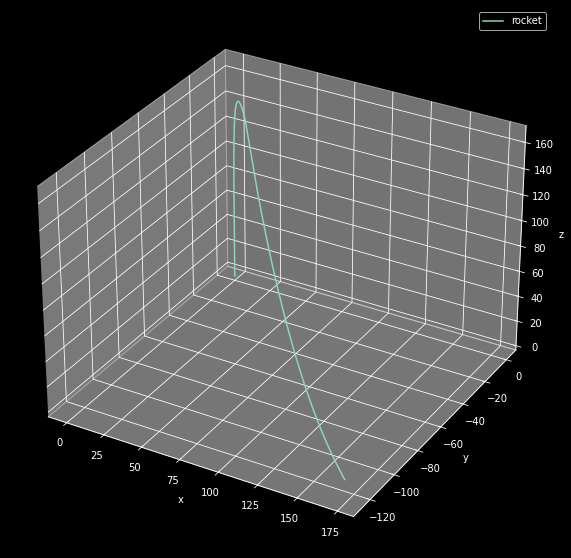

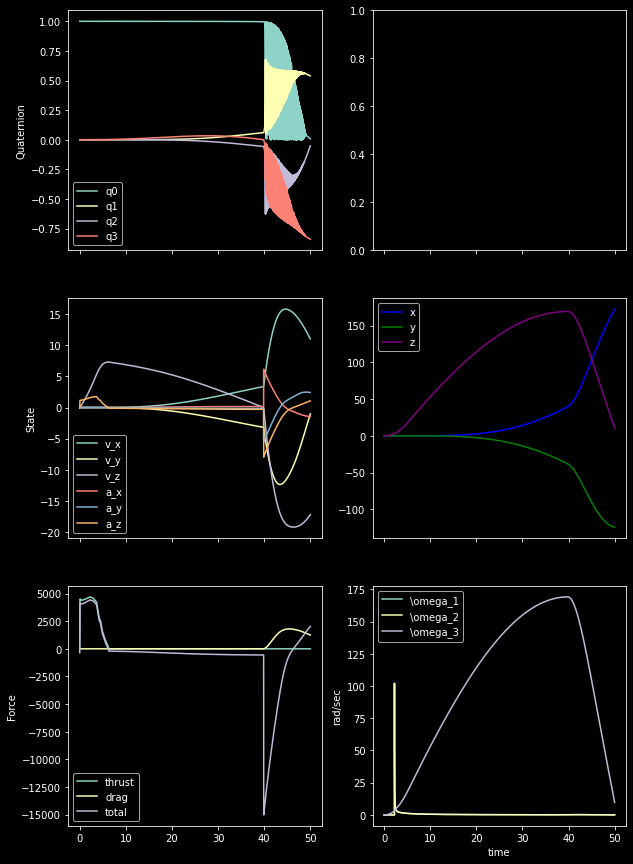

In [3]:
    # initialize state
    
    # quaternion initial conditions at 2 degrees
    initial_angle = 5 * np.pi / 180
    
    initial_q = np.array([np.cos(initial_angle / 2), 0, np.sin(initial_angle / 2), np.sin(initial_angle / 2)])
    
    u = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0,*initial_q,0,0,0])
    
    state = State(u)
    
    sensor_offset = np.array([0,-0.2,-0.5]) # location of the sensor relative to the tip
    sensor_u = np.array([0,0,0, 0, 0, 0, 0, 0, 0,*initial_q,0,0,0])
    
    total_time = 50
    dt = 0.01
    
    times = np.arange(0, total_time, dt)
    states = []
    thrusts = []
    drags = []
    total_forces = []
    
    
    
    
    masses = []
    for i in range(len(times)):
        if state.u[2] < 0 and i > 20:
            break
        ## calculate forces ##
        
        relative_wind = (wind_vector(*state.u[:3])*100 - state.u[3:6])
        
        # calculate drag force
        if state.u[5] < 0:
            drag = calculate_drag(
            velocity = state.u[3:6],
            air_density = calculate_air_density(state.u[2]),
            C_d = 2.2,
            A_s = 2.63)
            drag_force = np.zeros(3) if np.linalg.norm(state.u[3:6]) < 1e-5 else -drag * state.u[3:6] / np.linalg.norm(state.u[3:6])
            wind = relative_wind.dot(relative_wind) * calculate_air_density(state.u[2]) * (2.63)
            
        else:
            drag = calculate_drag(
            velocity = state.u[3:6],
            air_density = calculate_air_density(state.u[2]),
            C_d = 0.37,
            A_s = 0.066)
            drag_force = np.zeros(3) if np.linalg.norm(state.u[3:6]) < 1e-5 else -drag * state.u[3:6] / np.linalg.norm(state.u[3:6])
            wind = relative_wind.dot(relative_wind) * calculate_air_density(state.u[2]) * (0.066)

        # multiply by normalized velocity vector
                                #np.zeros(3))
        drags.append(drag_force[2])
        # calculate thrust force
        thrust = f_thrust(state.t)
        thrusts.append(thrust)
        heading_vector = np.array([0,0,1]) if np.linalg.norm(state.u[3:6]) < 1e-1 else state.u[3:6] / np.linalg.norm(state.u[3:6])
        thrust_force = heading_vector * thrust
        
        # calculate gravity force
        gravity = np.array([0, 0, -9.81]) * state.m_tot
        masses.append(state.m_tot)
        
        wind_force = np.zeros(3) if np.linalg.norm(state.u[3:6]) < 1e-5 else wind * relative_wind / np.linalg.norm(relative_wind)
        
        total_force = drag_force + thrust_force + gravity + wind_force
        total_forces.append(total_force[2])
        
        
        roll_torque = 1 * state.u[5]
        
        
        state.update_state(dt, forces = total_force, roll_torque = roll_torque)    
        states.append(state.u)

    #exit()
    # plotting results
    fig1 = plt.figure(figsize=(10, 10))
    position = fig1.add_subplot(111, projection='3d')
    position.plot([state[0] for state in states], [state[1] for state in states], [state[2] for state in states],label='rocket')
    position.set_xlabel('x')
    position.set_ylabel('y')
    position.set_zlabel('z')
    plt.legend()
    plt.show()
    
    # Second Plot: Subplots sharing the same x-axis
    fig2, ((ax0, ax1), (ax2, ax3), (ax4, ax5)) = plt.subplots(3, 2, figsize=(10, 15), sharex=True)
    ax0.plot(times, [state[9] for state in states], label='q0')
    ax0.plot(times, [state[10] for state in states], label='q1')
    ax0.plot(times, [state[11] for state in states], label='q2')
    ax0.plot(times, [state[12] for state in states], label='q3')
    ax0.legend()
    ax0.set_ylabel('Quaternion')
    
    
    ax3.plot(times, [state[0] for state in states], label='x', color = 'blue')
    ax3.plot(times, [state[1] for state in states], label='y', color = 'green')
    ax3.plot(times, [state[2] for state in states], label='z', color = 'purple')
    ax3.legend()

    ax2.plot(times, [state[3] for state in states], label='v_x')
    ax2.plot(times, [state[4] for state in states], label='v_y')
    ax2.plot(times, [state[5] for state in states], label='v_z')
    ax2.plot(times, [state[6] for state in states], label='a_x')
    ax2.plot(times, [state[7] for state in states], label='a_y')
    ax2.plot(times, [state[8] for state in states], label='a_z')
    ax2.legend()
    ax2.set_ylabel('State')

    # Subplot 2: x,y,z acceleration over time
    ax4.plot(times, thrusts, label="thrust")
    ax4.plot(times, drags, label="drag")
    ax4.plot(times, total_forces, label="total")
    ax4.set_ylabel('Force')
    ax4.legend()

    # Subplot 3: omega1, omega2, omega3 over time
    ax5.plot(times[:len(states)], [state[13] for state in states], label='\\omega_1')
    ax5.plot(times[:len(states)], [state[14] for state in states], label='\\omega_2')
    ax5.plot(times[:len(states)], [state[15] for state in states], label='\\omega_3')
    ax5.set_xlabel('time')
    ax5.set_ylabel('rad/sec')
    ax5.legend()
    plt.show()


## Import data into the sensor modeling section

In [4]:
state = states


In [5]:
def add_noise(mean, var):
    return np.random.normal(mean, var)


In [6]:
# define sensor relative position
sensor_pos = np.array([0.5, 0.0, -1])

def sensor_from_cg(t,sensor_pos):
    com = cg(t)
    return com + sensor_pos

sensor_from_cg(0, sensor_pos)


array([1.97144457, 1.47144457, 0.47144457])

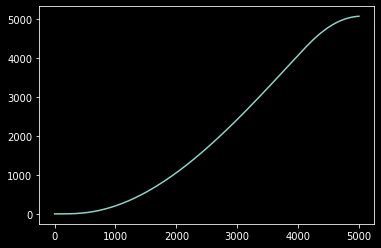

In [7]:
spins = [s[15] for s in state]
orientations = [0]
for i in range(1,len(spins)):
    orientations.append((orientations[-1] + spins[i-1]*0.01))
plt.plot(orientations)


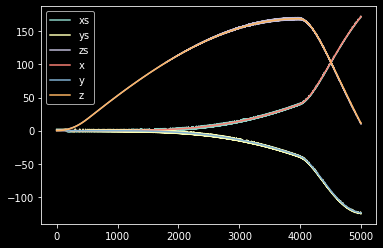

In [8]:

sensor_positions = []
for i in range(len(state)):
    sens_rel = sensor_from_cg(i*0.01, sensor_pos)
    abs_pos = state[i][:3]
    # rotate sens_rel about the quaternion
    ang = orientations[i]
    axis = state[i][3:6]
    q = np.array([np.cos(ang/2),
                  axis[0]*np.sin(ang/2),
                  axis[1]*np.sin(ang/2),
                  axis[2]*np.sin(ang/2)])
    
    sens_abs = rot_by_q(q,sens_rel)
    sensor_positions.append(abs_pos + sens_abs)
    
plt.plot(np.array(sensor_positions)[:,0],label='xs')
plt.plot(np.array(sensor_positions)[:,1],label='ys')
plt.plot(np.array(sensor_positions)[:,2],label='zs')
plt.plot([s[0] for s in state],label='x')
plt.plot([s[1] for s in state],label='y')
plt.plot([s[2] for s in state],label='z')
plt.legend()
# display plot in external window
plt.show(True)


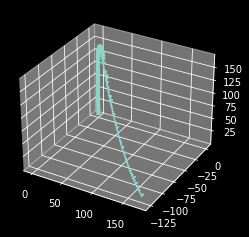

In [9]:
# %matplotlib qt
# plot 3d sensor positions
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot3D(np.array(sensor_positions)[:,0],np.array(sensor_positions)[:,1],np.array(sensor_positions)[:,2])


In [10]:
%matplotlib inline


## Part 2: Generating Sensor Data

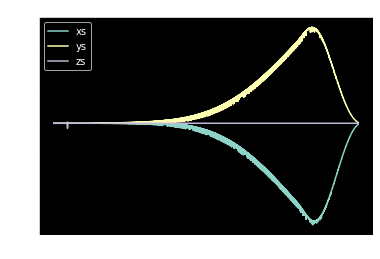

In [11]:
# Initialize sensor data
acc = [np.array(s[6:9]) for s in state]
x = np.array([np.array(s[:3]) for s in state])
w = [np.array(s[13:16]) for s in state]

sens_accel = []
for i in range(len(state)):
    sens_accel.append(acc[i] + np.cross(w[i],(np.cross(w[i],sensor_positions[i]))))

plt.plot(np.array(sens_accel)[:,0],label='xs')
plt.plot(np.array(sens_accel)[:,1],label='ys')
plt.plot(np.array(sens_accel)[:,2],label='zs')
plt.legend()
plt.show()


In [12]:
# add noise to sensor data
accel_var = 529000 # µg
gyro_var = 0.00225 # d/s

# convert to m/s^2
accel_var *= 9.81/1e6
gyro_var *= np.pi/180

sens_accel_noisy = []
for i in range(len(state)):
    sens_accel_noisy.append(sens_accel[i] + np.array([add_noise(0,accel_var),add_noise(0,accel_var),add_noise(0,accel_var)]))

sens_gyro_noisy = []
for i in range(len(state)):
    sens_gyro_noisy.append(w[i] + np.array([add_noise(0,gyro_var),add_noise(0,gyro_var),add_noise(0,gyro_var)]))


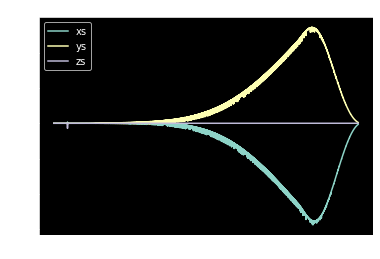

In [13]:
# plot noisy sensor data
plt.plot(np.array(sens_accel_noisy)[:,0],label='xs')
plt.plot(np.array(sens_accel_noisy)[:,1],label='ys')
plt.plot(np.array(sens_accel_noisy)[:,2],label='zs')
plt.legend()
plt.show()


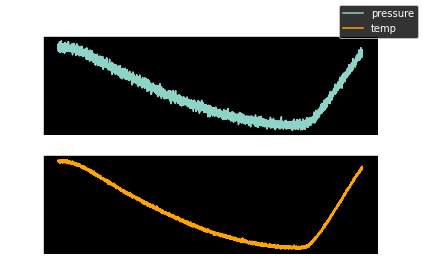

In [14]:
# generate pressure and temperature data
def height_to_pressure(height):
    # Constants for the barometric formula
    g = 9.80665  # Acceleration due to gravity (m/s^2)
    M = 0.0289644  # Molar mass of Earth's air (kg/mol)
    R = 8.31432  # Universal gas constant (J/(mol*K))
    T0 = 288.15  # Standard temperature at sea level (K)
    P0 = 101325  # Standard pressure at sea level (Pa)

    # Calculate the temperature at the given height
    temperature = T0 - 0.0065 * height

    # Calculate the pressure using the barometric formula
    pressure = P0 * np.power((1 - (0.0065 * height) / T0), (g * M) / (R * 0.0065)) / 1e3

    return pressure, temperature

pts = [height_to_pressure(s[2]) for s in state]
ps = [p[0] + add_noise(0,0.06) for p in pts] #hectopascals
ts = [p[1] + add_noise(0,0.01) for p in pts]

fig, (ax1, ax2) = plt.subplots(2, 1,sharex=True)
ax1.plot(ps,label='pressure')
ax2.plot(ts,label='temp',color='orange')
fig.legend()
plt.show()


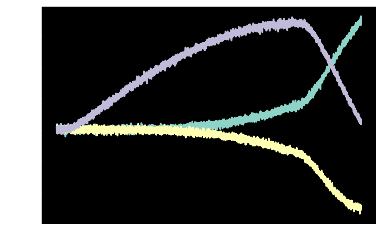

In [15]:
# generate GPS data (assume cartesian coordinates)
noisy_x  = [add_noise(x,3) for x in x]
plt.plot(np.array(noisy_x)[:,0],label='xs')
plt.plot(np.array(noisy_x)[:,1],label='ys')
plt.plot(np.array(noisy_x)[:,2],label='zs')


In [16]:
e ={
    'accel': sens_accel_noisy,
    'gyro': sens_gyro_noisy,
    'pressure': ps,
    'temp': ts,
    'gps': noisy_x,
    'sensor_pos': sensor_positions,
    'rocket_pos': np.array([s[:3] for s in state])
}


## Numpy Time

(5000, 3)


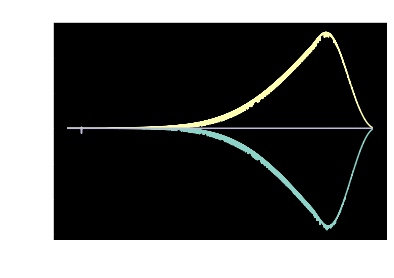

In [17]:
accel_sense = np.array(e['accel'])
print(accel_sense.shape)


# Plot accel over time
plt.plot(accel_sense)
plt.xlabel('Time')
plt.ylabel('Acceleration')
plt.title('Acceleration over Time')
plt.show()


(5000, 3)


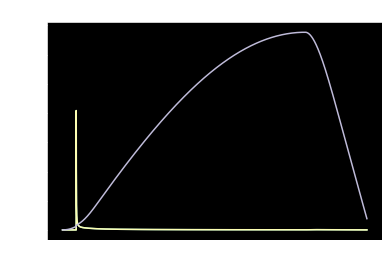

In [18]:
gyro_sense = np.array(e['gyro'])
print(gyro_sense.shape)

# Plot gyro over time
plt.plot(gyro_sense)
plt.xlabel('Time')
plt.ylabel('Gyro')
plt.title('Gyro over Time')
plt.show()


(5000,)


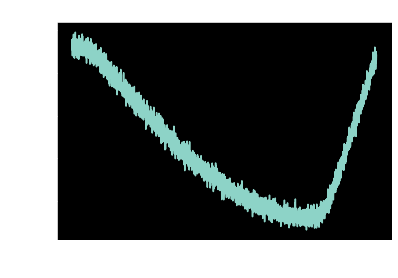

In [19]:
pressure_sense = np.array(e['pressure'])
print(pressure_sense.shape)

# Plot pressure over time
plt.plot(pressure_sense)
plt.xlabel('Time')
plt.ylabel('Pressure')
plt.title('Pressure over Time')
plt.show()


(5000,)


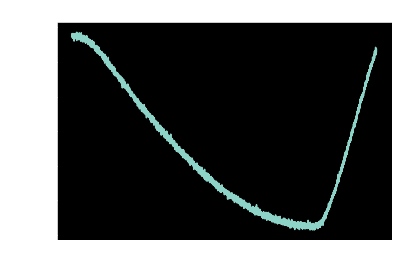

In [20]:
temp_sense = np.array(e['temp'])
print(temp_sense.shape)

# Plot temp over time
plt.plot(temp_sense)
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.title('Temperature over Time')
plt.show() 




In [21]:
baro_sense = np.vstack((np.array(e['pressure']), np.array(e['temp']))).T
baro_sense.shape


(5000, 2)

(5000, 3)


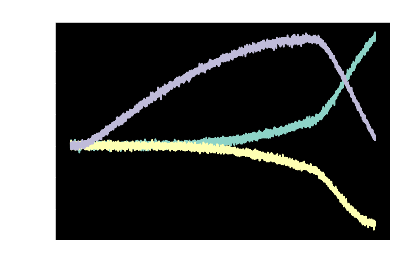

In [22]:
gps_sense = np.array(e['gps'])
print(gps_sense.shape)

# Plot gps over time
plt.plot(gps_sense)
plt.xlabel('Time')
plt.ylabel('GPS')
plt.title('GPS over Time')
plt.show() 


(5000, 3)


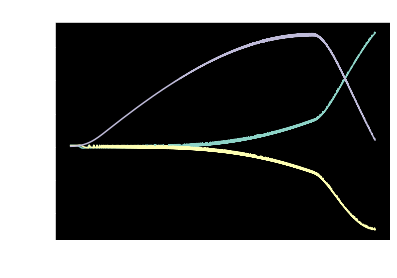

In [23]:
sensor_pos = np.array(e['sensor_pos'])
print(sensor_pos.shape)

# Plot sensor_pos over time
plt.plot(sensor_pos)
plt.xlabel('Time')
plt.ylabel('Sensor Position')
plt.title('Sensor Position over Time')
plt.show() 


(5000, 3)


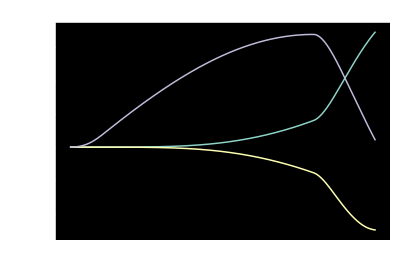

In [24]:
rocket_pos = np.array(e['rocket_pos'])
print(rocket_pos.shape)

# Plot rocket_pos over time
plt.plot(rocket_pos)
plt.xlabel('Time')
plt.ylabel('Rocket Position')
plt.title('Rocket Position over Time')
plt.show()


# Filtering the Data

In [25]:
import sys
sys.path.append("..")

from src.PredictorProvider import LinearPredictorProvider, UnscentedPredictorProvider
from src.CorrectorProvider import LinearCorrectorProvider, UnscentedCorrectorProvider


NUM_STATES = 16


## Evo Model

In [26]:
import quaternion

class BlackBoxPredictor(UnscentedPredictorProvider):
  def point_prop(self, state, dt):
    h_dt = dt**2 / 2

    pos = state[0:3]
    vel = state[3:6]
    accel = state[6:9]

    q = quaternion.as_quat_array(state[9:13, :].T)
    omega = state[13:16, :]

    
    pos_prime = pos + dt * vel + h_dt * accel
    vel_prime = vel + dt * accel
    accel_prime = accel

    rotated_q = quaternion.from_rotation_vector(dt * omega.T) * q

    # rotated_q /= rotated_q * rotated_q

    q_prime = quaternion.as_float_array(rotated_q.T).T
    
    omega_prime = omega
    
    return np.concatenate((pos_prime, vel_prime, accel_prime, q_prime, omega_prime))



## Obs Models

In [27]:
class GPSCorrector(LinearCorrectorProvider):
  def linear_obs_mat(self):
    # The three vec of pos is what we observe
    return np.block([np.eye(3), np.zeros((3, 13))]) 


In [28]:
class BaroCorrector(UnscentedCorrectorProvider):
  def obs_pred(self, state):
    height = state[2, :]

    # Constants for the barometric formula
    g = 9.80665  # Acceleration due to gravity (m/s^2)
    M = 0.0289644  # Molar mass of Earth's air (kg/mol)
    R = 8.31432  # Universal gas constant (J/(mol*K))
    T0 = 288.15  # Standard temperature at sea level (K)
    P0 = 101325  # Standard pressure at sea level (Pa)

    # Calculate the temperature at the given height
    temperature = T0 - 0.0065 * height

    # Calculate the pressure using the barometric formula
    pressure = P0 * np.power((1 - (0.0065 * height) / T0), (g * M) / (R * 0.0065)) / 1e3

    return np.vstack((pressure, temperature))
  

In [29]:
IMU_RADIUS = np.array([[1.97144457, 1.47144457, 0.47144457]])

class AccelCorrector(UnscentedCorrectorProvider):
  def obs_pred(self, state):
    g = 9.80665  # Acceleration due to gravity (m/s^2)

    # accel includes gravity
    accel = state[6:9, :] - np.array([[0, 0, g]]).T
    
    q = quaternion.as_quat_array(state[9:13, :].T)
    omega = state[13:16, :]

    # Rotate the acceleration vector from global to the body frame
    body_accel = quaternion.as_vector_part(q.conjugate() * quaternion.from_vector_part(accel.T) * q)
    
    # Subtract the centripetal acceleration
    inner_cross = np.cross(omega.T, IMU_RADIUS)
    outer_cross = np.cross(omega.T, inner_cross)
    sensor_accel = body_accel - outer_cross
    
    return sensor_accel.T


In [30]:
test_corrector = AccelCorrector(np.eye(3), noise_lerp=0.0, num_states=NUM_STATES)

test_corrector.obs_pred(np.ones((NUM_STATES, 33))
).shape


(3, 33)

In [31]:
class OmegaCorrector(UnscentedCorrectorProvider):
  def obs_pred(self, state):
    q = quaternion.as_quat_array(state[9:13, :].T)
    omega = state[13:16, :]

    # Rotate the angular velocity vector from global to the body frame
    body_omega = quaternion.as_vector_part(q.conjugate() * quaternion.from_vector_part(omega.T) * q).T

    return body_omega


In [32]:
test_corrector = OmegaCorrector(np.eye(3), noise_lerp=0.0, num_states=NUM_STATES)

test_corrector.obs_pred(np.ones((NUM_STATES, 33))
).shape


(3, 33)

## Setting up the filter

In [33]:

process_noise = 1e-5 * np.eye(NUM_STATES)

gps_noise = np.diag(3 * np.ones(3, ))

baro_noise = np.diag(np.array((0.06, 0.01)))

g = 9.80665  # Acceleration due to gravity (m/s^2)
accel_noise = np.diag(g * 529000e-6 * np.ones(3, ))
gyro_noise = np.diag(0.00225 * np.pi / 180 * np.ones(3, ))

# Init the predictors and correctors
# Note: Noise lerp is sort of an abandoned experiment (the filter estimates the sensor and process cov based off of an exponential filter) 
# setting it to 0.0 means that the filter will use the provided noise matrices without modification
state_predictor = BlackBoxPredictor(process_noise, noise_lerp=0.0, num_states=NUM_STATES)

gps_corrector = GPSCorrector(gps_noise, noise_lerp=0.0)

baro_corrector = BaroCorrector(baro_noise, noise_lerp=0.0, num_states=NUM_STATES)
accel_corrector = AccelCorrector(accel_noise, noise_lerp=0.0, num_states=NUM_STATES)
omega_corrector = OmegaCorrector(gyro_noise, noise_lerp=0.0, num_states=NUM_STATES)


## Running the filter

In [34]:
dt = 0.01
total_time = 50

times = np.arange(0, total_time, dt)

starting_state = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0 ,0 ,0, 0, 0, 0])


In [35]:
state_history = np.zeros((NUM_STATES, len(times)))
cov_history = np.zeros((NUM_STATES, NUM_STATES, len(times)))

state = starting_state
# cov = np.random.rand(NUM_STATES, NUM_STATES)
# cov += cov.T 
# cov /= 1e3

# cov += np.eye(NUM_STATES) * 1e-7



cov = np.eye(NUM_STATES) * 1e-3

for ind, t in enumerate(times):
  print("ind: ", ind, end='\r')
  state, cov = state_predictor.predict(state, cov, dt)

  state, cov = gps_corrector.correct(state, cov, gps_sense[ind, :], state_predictor)

  # state, cov = baro_corrector.correct(state, cov, baro_sense[ind, :], state_predictor)

  # state, cov = accel_corrector.correct(state, cov, accel_sense[ind, :], state_predictor)

  # state, cov = omega_corrector.correct(state, cov, gyro_sense[ind, :], state_predictor)

  state_history[:, ind] = state
  cov_history[:, :, ind] = cov


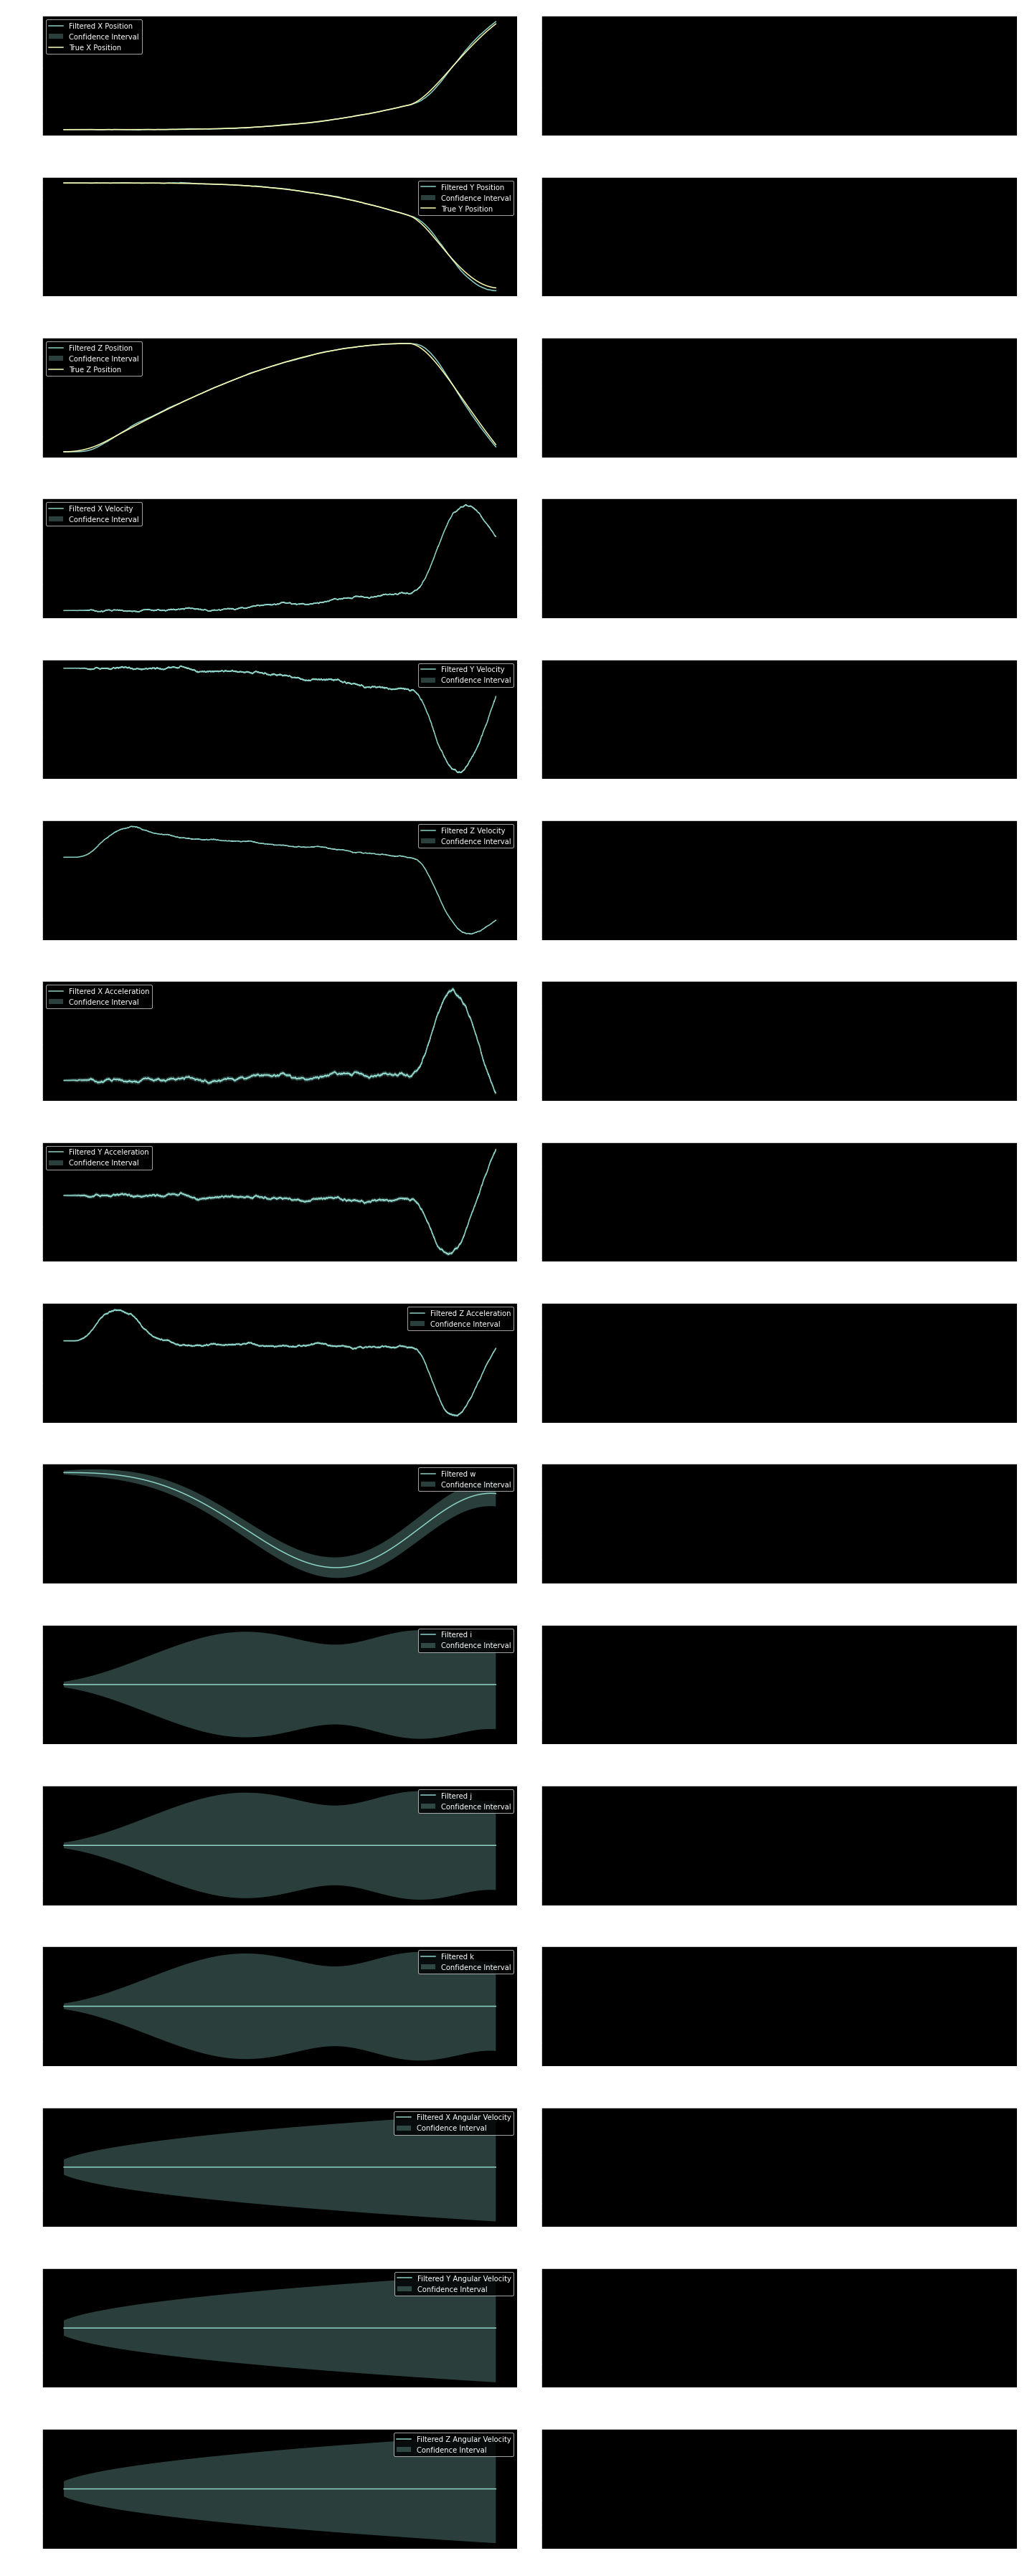

In [36]:
# Plotting position, velocity, acceleration, state variance, and residual over time
fig, axs = plt.subplots(3 * 3 + 4 + 3, 2, figsize=(20, 50))

for ind, label in enumerate(["X Position", "Y Position", "Z Position", "X Velocity", "Y Velocity", "Z Velocity", "X Acceleration", "Y Acceleration", "Z Acceleration", "w", "i", "j", "k", "X Angular Velocity", "Y Angular Velocity", "Z Angular Velocity"]):
  # Plotting position vs time
  axs[ind, 0].plot(times, state_history[ind, :], label='Filtered {}'.format(label))
  axs[ind, 0].fill_between(times, state_history[ind, :] - np.sqrt(cov_history[ind, ind, :]),
            state_history[ind, :] + np.sqrt(cov_history[ind, ind, :]),
            alpha=0.3, label='Confidence Interval')
  if ind < 3:
    axs[ind, 0].plot(times, rocket_pos[:, ind], label='True {}'.format(label))
  
  # if ind >= 6 and ind < 9:
  #  axs[ind, 0].plot(times, accel_sense[:, ind - 6], label='Sensor {}'.format(label))
  # axs[ind, 0].plot(times, true_states[ind, :], label='True {}'.format(label))
  # if ind == 0:
  #   axs[ind, 0].scatter(times, pos_measurements.T, label='Position Measurements', alpha=0.25)
  # if ind == 2:
  #   axs[ind, 0].scatter(times, accel_measurements.T, label='Acceleration Measurements', alpha=0.25)

  axs[ind, 0].set_xlabel('Time')
  axs[ind, 0].set_ylabel(label)
  axs[ind, 0].set_title('{} vs Time'.format(label))
  axs[ind, 0].legend()

  # Plotting residual vs time
  # axs[ind, 1].plot(times, state_history[ind, :] - true_states[ind, :], label='Residual')
  # axs[ind, 1].set_xlabel('Time')
  # axs[ind, 1].set_ylabel('Residual')
  # axs[ind, 1].set_title('{} Residual vs Time'.format(label))
  # axs[ind, 1].legend()


# # Plotting state variance vs time
# axs[3 - 3, 1].plot(times, cov_history[1, 1, :], label='Velocity Variance')
# axs[3 - 3, 1].set_xlabel('Time')
# axs[3 - 3, 1].set_ylabel('Variance')
# axs[3 - 3, 1].set_title('Velocity Variance vs Time')
# axs[3 - 3, 1].legend()



plt.tight_layout()
plt.show()


In [37]:
# %matplotlib widget
from matplotlib import rc
rc('animation', html='html5')

from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.animation as animation


STRIDE = 100

fig, ax = plt.subplots(figsize=(25, 25))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

im = ax.imshow(cov_history[:, :, 0], cmap='viridis', interpolation='nearest')
fig.colorbar(im, cax=cax, orientation='vertical')  # Add colorbar

def animate(i):
  print("Animating frame {} of {}".format(i, len(times[::STRIDE])), end='\r')
  ax.clear()
  im = ax.imshow(cov_history[:, :, i * STRIDE], cmap='viridis', interpolation='nearest')
  ax.set_title('Covariance Matrix at Time Step {}'.format(i))
  ax.set_xlabel('State Dimension')
  ax.set_ylabel('State Dimension')


ani = animation.FuncAnimation(fig, animate, frames=len(times[::STRIDE]), interval=10, blit=False)
plt.close()
ani
